# **Steganography**

In [28]:
import os
from PIL import Image # type: ignore
from cryptography.fernet import Fernet # type: ignore
import numpy as np # type: ignore
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim # type: ignore

### Generate Key untuk Enkripsi

In [29]:
# (jalankan sekali dan simpan kunci)
def generate_key():
    key = Fernet.generate_key()
    with open("secret.key", "wb") as key_file:
        key_file.write(key)

### Load Kunci Enkripsi

In [30]:
def load_key():
    return open("secret.key", "rb").read()

### Enkripsi dan Dekripsi menggunakan AES

In [31]:
def encrypt_message(message, key):
    cipher = Fernet(key)
    encrypted_message = cipher.encrypt(message.encode())
    return encrypted_message

def decrypt_message(encrypted_message, key):
    cipher = Fernet(key)
    decrypted_message = cipher.decrypt(encrypted_message).decode()
    return decrypted_message

### Menyisipkan Pesan pada Gambar menggunakan LSB Multi-Channel (RGB)

In [32]:
def encode_image(image_path, message, output_path):
    img = Image.open(image_path).convert("RGB")  # Pastikan gambar dalam mode RGB
    pixels = img.load()
    
    key = load_key()
    encrypted_message = encrypt_message(message, key)
    binary_message = ''.join(format(byte, '08b') for byte in encrypted_message) + '00000000'  # Terminator

    data_index = 0
    for y in range(img.height):
        for x in range(img.width):
            if data_index < len(binary_message):
                r, g, b = pixels[x, y]  # Pastikan mode RGB
                new_r = (r & ~1) | int(binary_message[data_index]) if data_index < len(binary_message) else r
                new_g = (g & ~1) | int(binary_message[data_index+1]) if data_index+1 < len(binary_message) else g
                new_b = (b & ~1) | int(binary_message[data_index+2]) if data_index+2 < len(binary_message) else b
                pixels[x, y] = (new_r, new_g, new_b)
                data_index += 3
            else:
                img.save(output_path)
                return
            
def decode_image(image_path):
    img = Image.open(image_path).convert("RGB")  # Pastikan mode RGB
    pixels = img.load()

    binary_message = ""

    for y in range(img.height):
        for x in range(img.width):
            r, g, b = pixels[x, y]
            binary_message += str(r & 1) + str(g & 1) + str(b & 1)

    # Konversi biner ke byte
    byte_message = [binary_message[i:i+8] for i in range(0, len(binary_message), 8)]
    
    try:
        # Hilangkan terminator "00000000" jika ada
        extracted_bytes = bytes([int(b, 2) for b in byte_message if b != "00000000"])

        # Load kunci
        key = load_key()

        # Coba lakukan dekripsi
        decrypted_message = decrypt_message(extracted_bytes, key)
        return decrypted_message

    except Exception:
        return "Tidak ada pesan tersembunyi di dalam gambar."


### How to Use

In [48]:
image_path = "original.png"
hidden_image_path = "hidden.png"

In [34]:
# 1️⃣ Jalankan sekali untuk membuat kunci enkripsi:
generate_key()

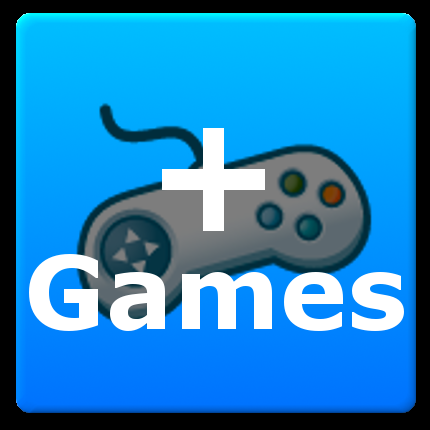

In [49]:
Image.open(image_path).convert("RGB")

In [50]:
# 2️⃣ Menyisipkan pesan ke dalam gambar
encode_image(
  image_path=image_path, 
  message="Pesan Rahasia!",
  output_path=hidden_image_path
  )
print("Pesan berhasil disisipkan!")

Pesan berhasil disisipkan!


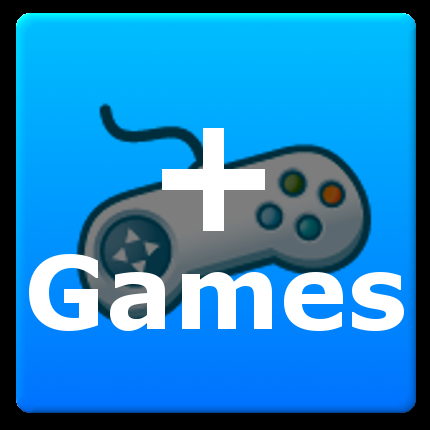

In [51]:
Image.open(hidden_image_path)

In [52]:
# 3️⃣ Mengekstrak dan mendekripsi pesan dari gambar
message = decode_image(image_path=hidden_image_path)
print("Pesan tersembunyi:", message)

Pesan tersembunyi: Pesan Rahasia!


### Evaluasi

In [60]:
def evaluate_image_quality(original_image, encoded_image):
    # Konversi gambar ke array numpy
    original_array = np.array(original_image)
    encoded_array = np.array(encoded_image)
    
    # Pastikan gambar cukup besar untuk dihitung SSIM
    if original_array.shape[0] < 7 or original_array.shape[1] < 7:
        raise ValueError("Gambar terlalu kecil untuk evaluasi SSIM.")
    
    # Evaluasi PSNR dan SSIM
    psnr_value = psnr(original_array, encoded_array)
    
    # Evaluasi SSIM dengan mengatur ukuran jendela dan channel axis
    ssim_value = ssim(original_array, encoded_array, multichannel=True, win_size=3, channel_axis=-1)
    
    return psnr_value, ssim_value

In [63]:
original_img = Image.open(image_path).convert('RGB')
encoded_img = Image.open(hidden_image_path).convert('RGB')

psnr_value, ssim_value = evaluate_image_quality(original_img, encoded_img)

print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")

PSNR: 79.96037143097689
SSIM: 0.9999895884014715


### Kesimpulan

4️⃣ Penjelasan Teknik yang Digunakan

Enkripsi AES dengan cryptography.Fernet

🔹 Sebelum pesan disisipkan, pesan dienkripsi untuk menambah keamanan.

🔹 Hanya yang memiliki kunci bisa mendekripsi pesan tersebut.

LSB Multi-Channel (RGB)

🔹 Menyisipkan bit pesan ke dalam semua kanal warna (R, G, B) agar lebih banyak data bisa disimpan.

🔹 Menggunakan 00000000 sebagai terminator agar mudah diekstrak.

5️⃣ Kesimpulan

✅ Teknik ini lebih aman karena menggunakan enkripsi AES sebelum penyisipan.

✅ LSB multi-channel meningkatkan kapasitas penyimpanan data dalam gambar.

✅ Pesan yang disisipkan hanya bisa dibaca oleh orang yang memiliki kunci enkripsi.